## Name         :- DARPAN GAUR
## Roll Number  :- CO21BTECH11004

In [3]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

# q3
import clip
import torch 
from torchvision import datasets, transforms
from tqdm import tqdm

In [4]:
# seed 
seed = 17
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [5]:
# set device
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

In [9]:
# read image
left = cv2.imread('left.png', -1)
right = cv2.imread('right.png', -1)

## Que 1(a)

In [14]:
def get_normalized_histogram(img):
    # custum histogram function
    hist = np.zeros(256)
    for i in img.flatten():
        hist[i] += 1
    hist = hist / np.sum(hist)
    return hist

In [21]:
def KL_divergence(p, q):
    p = np.array(p)
    q = np.array(q)
    # remove zeros
    p1 = p[(p != 0) | (q != 0)]
    q1 = q[(p != 0) | (q != 0)]
    return np.sum(p1 * np.log2(p1/q1))

p = [0.1, 0.2, 0.3, 0.4]
q = [0.2, 0.3, 0.4, 0.1]

print(f"KL Divergence of p and q is {KL_divergence(p, q)}")

KL Divergence of p and q is 0.45849625007211564


In [22]:
# KL divergence of left and right images
hist_left = get_normalized_histogram(left)
hist_right = get_normalized_histogram(right)

KL_lr = KL_divergence(hist_left, hist_right)
KL_rl = KL_divergence(hist_right, hist_left)

print(f"KL Divergence of left and right images is {KL_lr}")
print(f"KL Divergence of right and left images is {KL_rl}")

KL Divergence of left and right images is 0.015104015237387056
KL Divergence of right and left images is 0.014409785833354479


- As KL(left|right) != KL(right|left), the KL divergence is not symmetric.

## Que 1(b)

In [23]:
def get_cross_entropy(p, q):
    ce = 0
    for pi, qi in zip(p, q):
        if pi == 0 or qi == 0:
            continue
        ce += pi * np.log2(qi)
    return -ce

def get_jensenShannon_divergence(p, q):
    m = 0.5 * (p + q)
    return 0.5 * get_cross_entropy(p, m) + 0.5 * get_cross_entropy(q, m)

In [24]:
hist_left = get_normalized_histogram(left)
hist_right = get_normalized_histogram(right)

JS_lr = get_jensenShannon_divergence(hist_left, hist_right)
JS_rl = get_jensenShannon_divergence(hist_right, hist_left)

print(f"Jensen-Shannon Divergence of left and right images is {JS_lr}")
print(f"Jensen-Shannon Divergence of right and left images is {JS_rl}")

Jensen-Shannon Divergence of left and right images is 7.2721328579923465
Jensen-Shannon Divergence of right and left images is 7.2721328579923465


- Here JSD is symmetric, as JSD(left|right) = JSD(right|left), while KL is not symmetric, as seen in the previous question.

## Que 1(c)

In [25]:
def check_p_in_Pi(p, r, s):
    # check if marginals are equal
    rX = np.sum(p, axis=1)
    sY = np.sum(p, axis=0)
    if np.allclose(rX, r) and np.allclose(sY, s):
        return True
    return False

# Example 1 -> positive case
p_xy = np.array([[0.1, 0.2], [0.2, 0.5]])
r = np.array([0.3, 0.7])
s = np.array([0.3, 0.7])
print('Example 1:', check_p_in_Pi(p_xy, r, s))

# Example 2 -> negative case
p_xy = np.array([[0.1, 0.2], [0.2, 0.5]])
r = np.array([0.3, 0.7])
s = np.array([0.2, 0.8])
print('Example 2:', check_p_in_Pi(p_xy, r, s))

Example 1: True
Example 2: False


## Que 3

In [5]:
# load MINST dataset, train + test as dataset


# define a transform to normalize the data
transform_ = transforms.Compose([transforms.ToTensor()])

# download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform_)
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform_)

BATCH_SIZE = 256
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True)

In [6]:
model, preprocess = clip.load("ViT-L/14", device=device)   

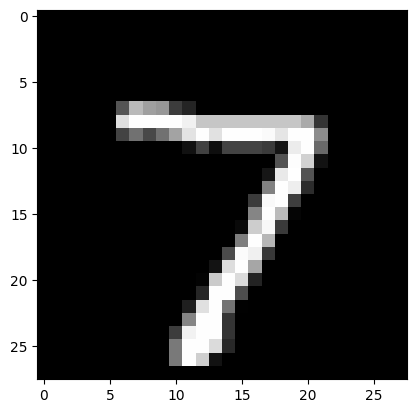

torch.Size([1, 3, 224, 224])

Top predictions:

           seven: 69.73%
             six: 15.56%
             two: 7.23%
           eight: 2.50%
            four: 2.31%


In [ ]:
# get image from testloader
# dataiter = iter(testloader)
# images, labels = next(dataiter)

testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False)

image_input = testset[0][0]
# plot image
plt.imshow(image_input, cmap='gray')
plt.show()
image_input = preprocess(image_input).unsqueeze(0).to(device)
print(image_input.shape)
lbl_text = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
text_inputs = torch.cat([clip.tokenize(f"the handwritten digit {lbl}") for lbl in lbl_text]).to(device)

# calculate features
with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_inputs)

# calculate similarity
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(5)

# print results
print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{lbl_text[index]:>16s}: {100 * value.item():.2f}%")


In [25]:
# take the first result and compute accuracy for the test set
correct = 0
total = 0
lbl_text = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
best_image_features=[]
lbl_original = []
best_image_labels = []
with torch.no_grad():
    for i, data in tqdm(enumerate(testset)):
        image_input = preprocess(data[0]).unsqueeze(0).to(device)
        text_inputs = torch.cat([clip.tokenize(f"the handwritten digit {lbl}") for lbl in lbl_text]).to(device)
        
        image_features = model.encode_image(image_input)
        text_features = model.encode_text(text_inputs)

        best_image_features.append(image_features)
        lbl_original.append(data[1])

        # calculate similarity
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        values, indices = similarity[0].topk(1)
        if indices[0] == data[1]:
            correct += 1

        best_image_labels.append(indices[0])

        total += 1  

print(f"Accuracy of the model on the 10000 test images: {100 * correct / total}%")

10000it [02:57, 56.37it/s]

Accuracy of the model on the 10000 test images: 55.09%


- We are getting 55.09% accuracy on the test set using the 'ViT-L14' model, also tried 'ViT-B16' but accuracy (~18%) was less.
- This is a good accuracy for zero-shot learning, as we are not using any training data for the classes.
- Similarity is calculated by computing cosine similarity between the image embeddings and 10 text embeddings. The most similar text embedding is selected as the class label. If it is correct, then the prediction is correct. 

In [26]:
# tsne
from sklearn.manifold import TSNE

feat = torch.cat(best_image_features)
best_lbls = torch.tensor(best_image_labels)
orig_lbls = torch.tensor(lbl_original)
feat = feat.cpu().numpy()
best_lbls = best_lbls.cpu().numpy()
orig_lbls = orig_lbls.cpu().numpy()

tsne = TSNE(n_components=2, random_state=0, n_jobs=-1)
X_2d = tsne.fit_transform(feat)

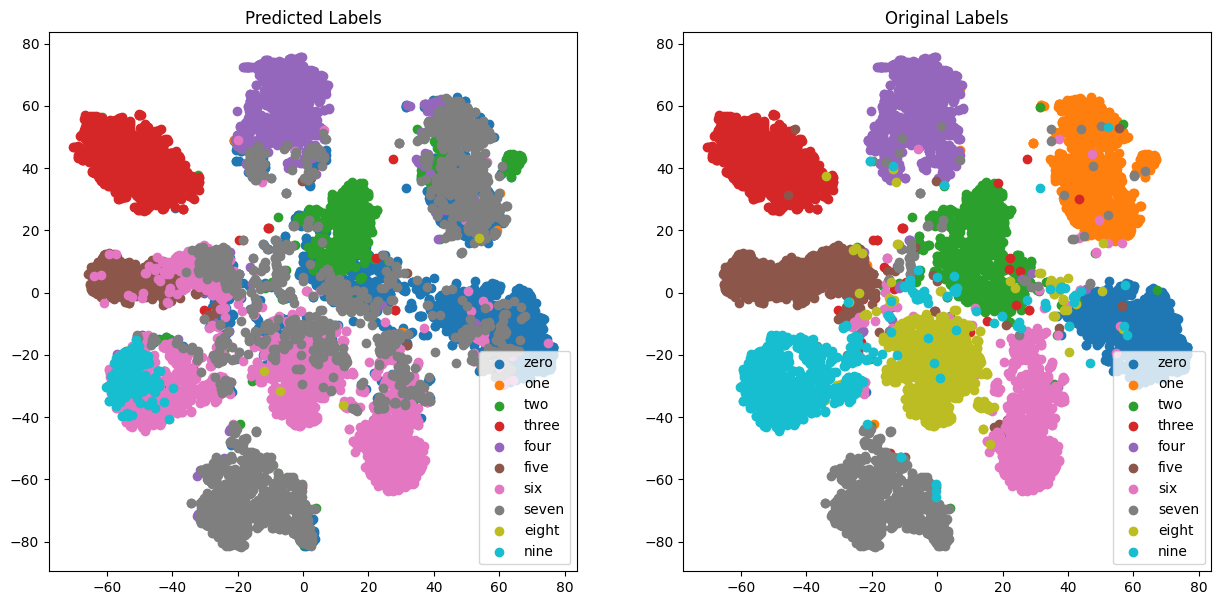

In [27]:
# plot tsne two subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

for i in range(10):
    axs[0].scatter(X_2d[best_lbls == i, 0], X_2d[best_lbls == i, 1], label=lbl_text[i])
    axs[0].set_title('Predicted Labels')
    axs[0].legend()
    axs[1].scatter(X_2d[orig_lbls == i, 0], X_2d[orig_lbls == i, 1], label=lbl_text[i])
    axs[1].set_title('Original Labels')
    axs[1].legend()

plt.show()



- TSNE plot [predicted class] for best matches has some overlapping classes, which is expected as we are using zero-shot learning.
- We can see that the model is able to find some good matches for the classes, but there are some classes where the model is not able to find good matches.